### 1. Define the Shared Workflow State

In [29]:
from typing import TypedDict, Annotated, Optional, Dict, Any, Literal, List

## Reducers
from langgraph.graph.message import add_messages

class ClinicalWorkflowState(TypedDict):

    # Conversation AI Agent output
    messages: Annotated[list,add_messages]
    intent: Literal["appointment", "order_medicine", "reminder"]
    extracted_entities: Dict[str, Any]
    dialog_context: Dict[str, Any]
    ready_for_routing: bool

    # Router output
    route: Literal["appointment", "order_medicine", "reminder"]

    # Intake output
    structured_data: Dict[str, Any]

    # Context Retrieval output
    context: Dict[str, Any]

    # Triage output
    triage_confirmed: bool
    triage: Dict[str, Any]

    # Validation output
    is_valid: bool
    validation_errors: Optional[str]

    # Scheduling output
    appointment_confirmed: bool
    appointment_details: Optional[Dict[str, Any]]

    # Pharmacy
    medication_summary: Optional[Dict[str, Any]]

    # Reminders
    reminders: Optional[List[str]]

### 2. Define the LLM

In [30]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    api_key="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",
    # model="qwen/qwen3-32b",
    model="llama-3.3-70b-versatile",
    timeout=60
)

### 3. Define the Agents

#### 3.1 Conversation AI Agent (Chatbot)

In [31]:
def conversation_ai_agent(state: ClinicalWorkflowState):

    system_prompt = """
    You are a clinical conversational assistant.

    Your tasks:
    1. You are expert in healthcare domain, specially in clinical and administrative domain
    2. Continue the conversation naturally.
    3. Identify ONE intent from:
        - appointment
        - order_medicine
        - reminder
    4. Extract relevant entities (specialty, date, time, medication, dosage, etc.).
    5. Decide whether enough information is available to proceed.

    Respond ONLY in valid JSON:
    {
    "reply": "...",
    "intent": "...",
    "entities": {...},
    "ready_for_routing": true/false
    }
    """

    response = llm.invoke(
        [{"role": "system", "content": system_prompt}] + state["messages"]
    )

    import json
    parsed = json.loads(response.content)

    print(parsed)

    return {
        "messages": [{"role": "assistant", "content": parsed["reply"]}],
        "intent": parsed["intent"],
        "extracted_entities": parsed.get("entities", {}),
        "dialog_context": {
            "last_intent": parsed["intent"]
        },
        "ready_for_routing": parsed["ready_for_routing"]
    }

#### 3.2 Workflow Agents

#### a) Router Agent
Purpose: Decide whether the request is clinical or administrative.

In [32]:
def router_agent(state: ClinicalWorkflowState):

    # Multi Intent Handling - TBD
    if state["intent"] == "appointment":
        route = "appointment"
    elif state["intent"] == "order_medicine":
        route = "order_medicine"
    elif state["intent"] == "reminder":
        route = "reminder"
    else:
        route = "none"

    return {"route": route}



#### b) Intake Agent

Purpose: Extract and normalize information into structured form.

In [33]:
def intake_agent(state: ClinicalWorkflowState):
    
    # This will retrive patient data from extracted_entities
    # Intelligent Extraction using LLM, DB & Tool call - TBD
    entities = state["extracted_entities"]

    structured_data = {
        "patient_name": entities.get("patient_name"),
        "requested_doctor_name": entities.get("doctor_name"),
        "requested_specialty": entities.get("specialty"),
        "preferred_date": entities.get("date"),
        "preferred_time": entities.get("time"),
        "symptoms": entities.get("symptoms")
    }

    return {"structured_data": structured_data}


#### c) Context Retrieval Agent

Purpose: Enrich the workflow with historical or supporting context.

In [34]:
def context_retrieval_agent(state: ClinicalWorkflowState):
    
    # Synthetic / mock context (to be retrieved from DB - TBD)
    context = {
        "previous_conditions": ["Hypertension"],
        "last_visit": "2025-08-12",
        "risk_level": "medium"
    }

    return {"context": context}


#### d) Triage Reasoning Agent

Purpose: Classify urgency and workflow priority.

In [35]:
def triage_reasoning_agent(state: ClinicalWorkflowState):
    context = state["context"]

    # Urgency Reasoning will be determined using LLM
    # TBD
    # Synthetic / mock context
    if "Hypertension" in context.get("previous_conditions", []):
        urgency = "moderate"
    else:
        urgency = "low"

    triage = {
        "urgency": urgency,
    }

    return {"triage": triage}


#### e) Validation Agent

Purpose: Prevent propagation of incomplete or inconsistent data.

In [36]:
def validation_agent(state: ClinicalWorkflowState):
    data = state["structured_data"]

    required_fields = ["patient_name", "requested_doctor_name", "requested_specialty", "preferred_date", "preferred_time"]
    missing = [f for f in required_fields if f not in data]

    if missing:
        return {
            "is_valid": False,
            "validation_errors": f"Missing fields: {missing}"
        }

    return {"is_valid": True, "validation_errors": None}


#### f) Scheduling Agent

Purpose: Automate appointment booking.

In [37]:
def scheduling_agent(state: ClinicalWorkflowState):
    appointment_details = {
        "doctor": state["structured_data"]["requested_doctor_name"],
        "specialty": state["structured_data"]["requested_specialty"],
        "date": state["structured_data"]["preferred_date"],
        "time": state["structured_data"]["preferred_time"]
    }

    # Update DB with appointment details
    # TBD

    return {"appointment_details": appointment_details}


#### g) Pharmacy Agent

Purpose: Handle medication-related post-visit tasks.

In [38]:
def pharmacy_agent(state: ClinicalWorkflowState):
    """
    Simulates extraction and interpretation of medication 
    instructions following a clinical encounter.
    """

    medication_summary = {
        "medication_name": "Amlodipine",
        "dosage": "5 mg",
        "frequency": "Once daily",
        "duration": "30 days",
        "refill_required": False
    }

    # Update DB with medicine + order details
    # TBD

    return {"medication_summary": medication_summary}


#### h) Reminder Agent

Purpose: Generate adherence and follow-up reminders.

In [39]:
def reminder_agent(state: ClinicalWorkflowState):
    reminders = []

    # Synthetic / mock context (to be retrieved from DB - TBD)
    if state.get("appointment_details"):
        reminders.append(
            f"Reminder: Appointment with {state['appointment_details']['doctor']} ({state['appointment_details']['specialty']}) "
            f"on {state['appointment_details']['date']} at {state['appointment_details']['time']}"
        )

    if state.get("medication_summary"):
        reminders.append(
            f"Medication Reminder: Take {state['medication_summary']['medication_name']} "
            f"{state['medication_summary']['dosage']} "
            f"{state['medication_summary']['frequency']}"
        )

    reminders.append("Follow-up reminder scheduled for routine check-up.")

    return {"reminders": reminders}


### 3. Build the LangGraph Workflow

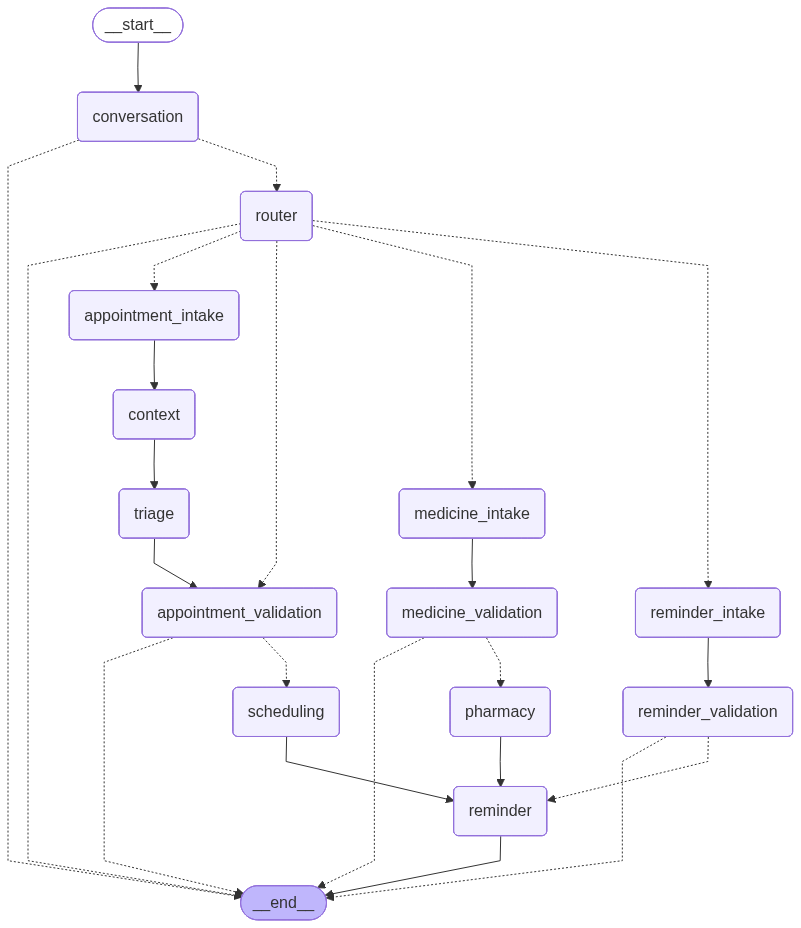

In [43]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph(ClinicalWorkflowState)

# Register agents
graph.add_node("conversation", conversation_ai_agent)
graph.add_node("router", router_agent)
graph.add_node("appointment_intake", intake_agent)
graph.add_node("medicine_intake", intake_agent)
graph.add_node("reminder_intake", intake_agent)
graph.add_node("context", context_retrieval_agent)
graph.add_node("triage", triage_reasoning_agent)
graph.add_node("appointment_validation", validation_agent)
graph.add_node("medicine_validation", validation_agent)
graph.add_node("reminder_validation", validation_agent)
graph.add_node("scheduling", scheduling_agent)
graph.add_node("pharmacy", pharmacy_agent)
graph.add_node("reminder", reminder_agent)

# Entry point
graph.add_edge(START,"conversation")

# Conditional Routing Logic
def route_from_conversation(state: ClinicalWorkflowState):
    if state["ready_for_routing"]:
        return "router"
    else:
        return END

graph.add_conditional_edges(
    "conversation",
    route_from_conversation,
    {
        "router": "router",
        END: END
    }
)

def route_from_router(state: ClinicalWorkflowState):
    if state["route"] == "appointment":
        if state["triaage_confirmed"]:
            "appointment_validation"
        else:
            return "appointment_intake"
    elif state["route"] == "order_medicine":
        return "medicine_intake"
    elif state["route"] == "reminder":
        return "reminder_intake"
    return END

graph.add_conditional_edges(
    "router",
    route_from_router,
    {
        "appointment_intake": "appointment_intake",
        "appointment_validation": "appointment_validation",
        "medicine_intake": "medicine_intake",
        "reminder_intake": "reminder_intake",
        END: END
    }
)

# Define Sequential Dependencies
graph.add_edge("appointment_intake", "context")
graph.add_edge("context", "triage")
graph.add_edge("triage", "appointment_validation")

# Validation Gate (Critical for Clinical Safety)
def validation_gate(state: ClinicalWorkflowState):
    if state["is_valid"]:
        return "scheduling"
    return END

graph.add_conditional_edges(
    "appointment_validation",
    validation_gate,
    {
        "scheduling": "scheduling",
        END: END
    }
)

# Define Sequential Dependencies
graph.add_edge("medicine_intake", "medicine_validation")

# Validation Gate (Critical for Clinical Safety)
def validation_gate(state: ClinicalWorkflowState):
    if state["is_valid"]:
        return "pharmacy"
    return END

graph.add_conditional_edges(
    "medicine_validation",
    validation_gate,
    {
        "pharmacy": "pharmacy",
        END: END
    }
)

# Define Sequential Dependencies
graph.add_edge("reminder_intake", "reminder_validation")

# Validation Gate (Critical for Clinical Safety)
def validation_gate(state: ClinicalWorkflowState):
    if state["is_valid"]:
        return "reminder"
    return END

graph.add_conditional_edges(
    "reminder_validation",
    validation_gate,
    {
        "reminder": "reminder",
        END: END
    }
)

graph.add_edge("scheduling", "reminder")
graph.add_edge("pharmacy", "reminder")
graph.add_edge("reminder", END)

app = graph.compile()
app

### 99. Test Run

In [41]:
result = app.invoke({
    "messages": "Hi, my name is Sourav Das and " +
    "I need to schedule a cardiology appointment next Monday at 10 am"
})

print("Final Output:")
print(result)

{'reply': "Hello Sourav Das, I've noted your request for a cardiology appointment. Next Monday at 10 am is the preferred time. Is this appointment for a routine check-up or do you have a specific concern?", 'intent': 'appointment', 'entities': {'patient_name': 'Sourav Das', 'specialty': 'cardiology', 'date': 'next Monday', 'time': '10 am'}, 'ready_for_routing': True}


KeyError: 'triaage_confirmed'

In [ ]:
for event in app.stream({
    "messages": "Hi, my name is Sourav Das and " +
    "I need to schedule appointment with Dr. Smith (cardiology) next Monday at 10 am"
}, stream_mode="updates"):
    print(event)

{'reply': "Hello Sourav Das, I've noted your request for an appointment with Dr. Smith, a cardiologist, next Monday at 10 am. I'll check the availability of Dr. Smith.", 'intent': 'appointment', 'entities': {'patient_name': 'Sourav Das', 'doctor_name': 'Dr. Smith', 'specialty': 'cardiology', 'day': 'next Monday', 'time': '10 am'}, 'ready_for_routing': True}
{'conversation': {'messages': [{'role': 'assistant', 'content': "Hello Sourav Das, I've noted your request for an appointment with Dr. Smith, a cardiologist, next Monday at 10 am. I'll check the availability of Dr. Smith."}], 'intent': 'appointment', 'extracted_entities': {'patient_name': 'Sourav Das', 'doctor_name': 'Dr. Smith', 'specialty': 'cardiology', 'day': 'next Monday', 'time': '10 am'}, 'dialog_context': {'last_intent': 'appointment'}, 'ready_for_routing': True}}
{'router': {'route': 'appointment'}}
{'appointment_intake': {'structured_data': {'patient_name': 'Sourav Das', 'requested_doctor_name': 'Dr. Smith', 'requested_spe

In [ ]:
for event in app.stream({
    "messages": "I want to refill Amlodipine for 30 days. I take 5 mg once daily"
}, stream_mode="updates"):
    print(event)

{'reply': 'I can help you with refilling your Amlodipine prescription. To confirm, you would like to refill Amlodipine 5mg, once daily, for a 30-day supply. Is that correct?', 'intent': 'order_medicine', 'entities': {'medication': 'Amlodipine', 'dosage': '5mg', 'frequency': 'once daily', 'duration': '30 days'}, 'ready_for_routing': True}
{'conversation': {'messages': [{'role': 'assistant', 'content': 'I can help you with refilling your Amlodipine prescription. To confirm, you would like to refill Amlodipine 5mg, once daily, for a 30-day supply. Is that correct?'}], 'intent': 'order_medicine', 'extracted_entities': {'medication': 'Amlodipine', 'dosage': '5mg', 'frequency': 'once daily', 'duration': '30 days'}, 'dialog_context': {'last_intent': 'order_medicine'}, 'ready_for_routing': True}}
{'router': {'route': 'order_medicine'}}
{'medicine_intake': {'structured_data': {'patient_name': None, 'requested_doctor_name': None, 'requested_specialty': None, 'preferred_date': None, 'preferred_ti

In [ ]:
for event in app.stream({
    "messages": "Send me a reminder 24 hours before the appointment with Dr. Smith (cardiology) which is scheduled on coming Monday at 10 am"
}, stream_mode="updates"):
    print(event)

{'reply': 'I have noted your request for a reminder. You will receive a reminder 24 hours before your cardiology appointment with Dr. Smith on Monday at 10 am.', 'intent': 'reminder', 'entities': {'specialty': 'cardiology', 'doctor': 'Dr. Smith', 'day': 'Monday', 'time': '10 am', 'notification_time': '24 hours before'}, 'ready_for_routing': True}
{'conversation': {'messages': [{'role': 'assistant', 'content': 'I have noted your request for a reminder. You will receive a reminder 24 hours before your cardiology appointment with Dr. Smith on Monday at 10 am.'}], 'intent': 'reminder', 'extracted_entities': {'specialty': 'cardiology', 'doctor': 'Dr. Smith', 'day': 'Monday', 'time': '10 am', 'notification_time': '24 hours before'}, 'dialog_context': {'last_intent': 'reminder'}, 'ready_for_routing': True}}
{'router': {'route': 'reminder'}}
{'reminder_intake': {'structured_data': {'patient_name': None, 'requested_doctor_name': None, 'requested_specialty': 'cardiology', 'preferred_date': None,